## 1. 필요한 패키지 불러오기

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from glob import glob
import re
from collections import defaultdict

## 2. 사용할 데이터와 모델 불러오기

In [2]:
def images_load(img_path):
    img_path = "./images/" + "*"
    list_path = glob("./images/*")


    images = defaultdict()
    for path in list_path:
        image_array = cv2.imread(path)
        name = path.split("/")[-1]
        name = re.sub(".jpg", "", name)
        images[name] = image_array
    return dict(images)

img_orig = images_load("./images")
del img_orig["background"]

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = './models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ./models
model loaded successfully!


## 3. 불러온 모델을 적용하여 segmentation 찾기

In [5]:
def img_mask_pred(images:"dict"):
    cp_images = images.copy()
    for image in cp_images:
        origin_shape = cp_images[image].shape
        # segmentation mask 예측
        cp_images[image] = MODEL.run(cp_images[image])
        resize_shape, seg_map = cp_images[image]
        print(image)
        print(f"resize before : {origin_shape}") # (Height, Width, Channel)
        print(f"resize after : {resize_shape.shape}") # (Height, Width, Channel)
        print(f"seg_map_max : {seg_map.max()}")
    return cp_images

run_img_orig = img_mask_pred(img_orig)
resize_images = list(map(lambda x: x[0], list(run_img_orig.values())))

girl
resize before : (368, 512, 3)
resize after : (368, 513, 3)
seg_map_max : 15
profile
resize before : (1045, 1045, 3)
resize after : (513, 513, 3)
seg_map_max : 15
dog
resize before : (225, 225, 3)
resize after : (513, 513, 3)
seg_map_max : 12


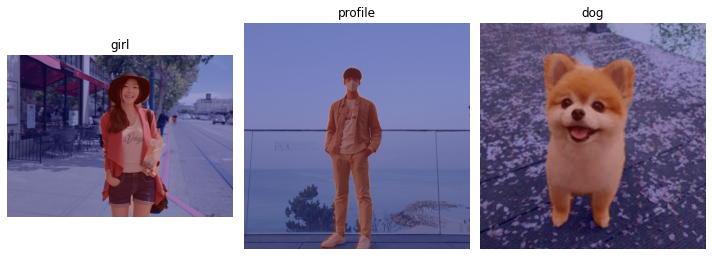

In [70]:
def mask_show(run_img_orig):
    fig, axes = plt.subplots(1, len(run_img_orig), figsize = (10, 10))
    if len(run_img_orig) != 1:
        axes = axes.ravel()
    else:
        axes = [axes]
    label = list(run_img_orig.keys())
    
        
    result = defaultdict()
    for ind, axis in enumerate(axes):
        image, seg_map = run_img_orig[label[ind]]
        img_show = image.copy()
        # seg_map에서 값이 높은 부분은 예측된 객체의 위치임 나머지는 0
        seg_map_max = seg_map.max()
        seg_map = np.where(seg_map == seg_map_max, seg_map_max, 0)
        # 정규화
        img_mask = seg_map * (255 / seg_map_max)
        img_mask = img_mask.astype(np.uint8)
        result[label[ind]] = img_mask
        
        # 원본 이미지에서 모델이 찾은 segmentation 색으로 구분하기 위함
        color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
        img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

        axis.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
        axis.set_title(label[ind])
        axis.axis("off")

    plt.tight_layout()
    plt.show()
    return dict(result)
    
img_mask = mask_show(run_img_orig)

## 4. 아웃포커싱 적용하기

In [7]:
def outfocus_filter(img_mask, img_orig):
    labels = list(img_mask.keys())

    cp_img_mask = img_mask.copy()
    cp_img_orig = img_orig.copy()

    img_concat = defaultdict()

    for label in labels:
        # 모델에서 나온 결과물인 mask의 크기를 원래 이미지 크기에 맞게 크기 수정
        img_mask_up = cv2.resize(cp_img_mask[label], cp_img_orig[label].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
        # 확실한 경계를 정하기 위해 중간값 128을 기준으로 128이하는 0 이상은 255 임계값 설치
        _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

        # 원본 배경 전체에 흐림 효과 적용
        blur_image = cv2.blur(cp_img_orig[label], (13, 13))
        blur_image = cv2.cvtColor(blur_image, cv2.COLOR_BGR2RGB)

        # mask 부분은 255 나머지는 모두 0
        img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2RGB)
        # mask 부분은 0 나머지는 모두 255
        img_bg_mask = cv2.bitwise_not(img_mask_color)
        # mask 부분은 0 나머지는 blur background
        img_bg_blur = cv2.bitwise_and(blur_image, img_bg_mask)

        # mask의 위치 정보가 담긴 img_mask_color가 255면 객체 이미지 아니면 배경 이미지
        img_concat[label] = np.where(img_mask_color==255, cp_img_orig[label], img_bg_blur)
        img_concat[label] = cv2.cvtColor(img_concat[label], cv2.COLOR_BGR2RGB)
    return img_concat

img_concat = outfocus_filter(img_mask, img_orig)

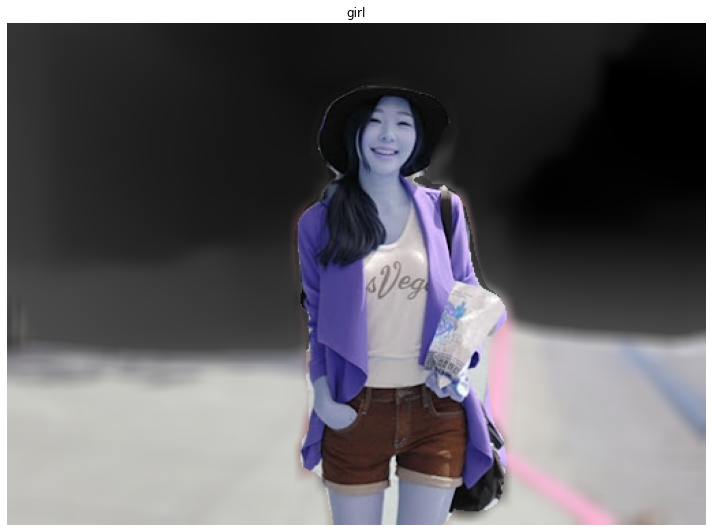

In [78]:
def show_images(img_concat):
    fig, axes = plt.subplots(1, len(img_concat), figsize = (10, 10))
    if len(img_concat) != 1:
        axes = axes.ravel()
    else:
        axes = [axes]
    labels = list(img_concat.keys())

    for ind, axis in enumerate(axes):
        axis.imshow(img_concat[labels[ind]])
        axis.set_title(labels[ind])
        axis.axis("off")

    plt.tight_layout()
    plt.show()
    
show_images(img_concat)

## 5. 크로마키 적용하기

### 크로마키 이미지 만들기

In [9]:
def cromaki_filter(img_mask, img_orig):
    labels = list(img_mask.keys())

    cp_img_mask = img_mask.copy()
    cp_img_orig = img_orig.copy()

    img_concat = defaultdict()

    for label in labels:
        # 모델에서 나온 결과물인 mask의 크기를 원래 이미지 크기에 맞게 크기 수정
        img_mask_up = cv2.resize(cp_img_mask[label], cp_img_orig[label].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
        # 확실한 경계를 정하기 위해 중간값 128을 기준으로 128이하는 0 이상은 255 임계값 설치
        _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

        # 원본 배경 전체에 초록색으로 변경
        cromaki_image = np.full_like(img_orig[label], 0)
        cromaki_image[:,:,1] = 255
        cromaki_image = cv2.cvtColor(cromaki_image, cv2.COLOR_BGR2RGB)

        # mask 부분은 255 나머지는 모두 0
        img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2RGB)
        # mask 부분은 0 나머지는 모두 255
        img_bg_mask = cv2.bitwise_not(img_mask_color)
        # mask 부분은 0 나머지는 blur background
        img_bg_cromaki = cv2.bitwise_and(cromaki_image, img_bg_mask)

        # mask의 위치 정보가 담긴 img_mask_color가 255면 객체 이미지 아니면 배경 이미지
        img_concat[label] = np.where(img_mask_color==255, cp_img_orig[label], img_bg_cromaki)
        img_concat[label] = cv2.cvtColor(img_concat[label], cv2.COLOR_BGR2RGB)
    return img_concat

cromaki_concat = cromaki_filter(img_mask, img_orig)

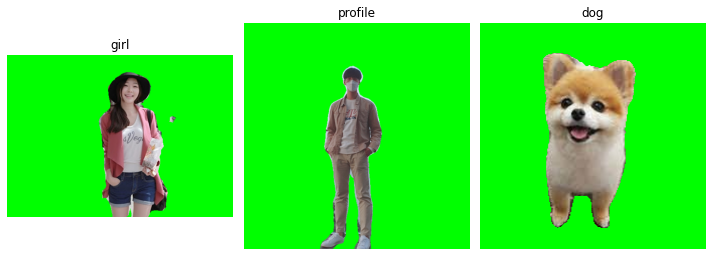

In [10]:
show_images(cromaki_concat)

### 크로마키 배경에 들어갈 배경 이미지 가져오기

In [11]:
back_img = cv2.imread("./images/background.jpg")
back_img = cv2.cvtColor(back_img, cv2.COLOR_BGR2RGB)

### 불러온 배경으로 크로마키 이미지에 적용하기

In [12]:
def change_background(cromaki_concat, back_img):
    labels = list(cromaki_concat.keys())
    result = defaultdict()
    
    for label in labels:
        cp_back_img = back_img.copy()
        cp_fore_img = cromaki_concat[label].copy()
        cp_back_img = cv2.resize(cp_back_img, cp_fore_img.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    
        R_img = np.where(cp_fore_img[:,:,0] == 0, cp_back_img[:,:,0], cp_fore_img[:,:,0])
        G_img = np.where(cp_fore_img[:,:,1] == 255, cp_back_img[:,:,1], cp_fore_img[:,:,1])
        B_img = np.where(cp_fore_img[:,:,2] == 0, cp_back_img[:,:,2], cp_fore_img[:,:,2])
        result[label] = np.stack([R_img, G_img, B_img], axis = 2)

    return result

changed_imgs = change_background(cromaki_concat, back_img)

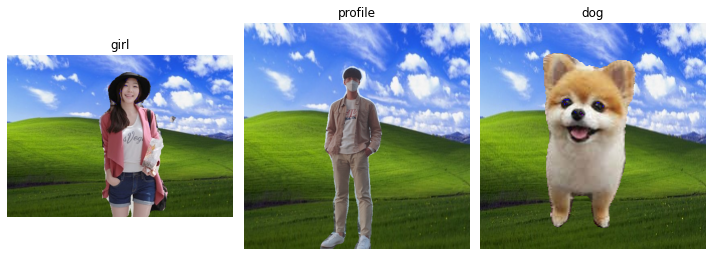

In [13]:
show_images(changed_imgs)

## 6. 사진에서 문제점 찾기

### 문제점.1 : girl 사진에서 의문의 점 발생

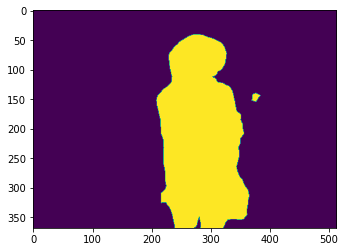

In [14]:
plt.imshow(img_mask["girl"])

맨 앞에만 있는 여자의 사진을 세그멘테이션을 하려고 하였는데 마스크를 만든 결과에 이상한 점이 하나 생겨 있습니다.

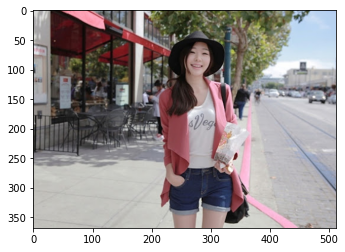

In [138]:
tmp_girl = img_orig["girl"].copy()
tmp_girl = cv2.cvtColor(tmp_girl, cv2.COLOR_BGR2RGB)
plt.imshow(tmp_girl)

점의 원인을 찾고자 원본 사진을 확인한 결과 정면 여성 사진을 제외하고 뒤에도 여성이 있는 것을 발견하였습니다.  
해당 문제는 모델의 성능이 너무 좋아서 뒤에 있는 여성까지 찾아버리는 것이 문제라고 볼 수 있습니다.

이러한 문제를 어떻게 해결해야 할까요?

해당 문제를 이미지의 깊이를 구분해주어서 가장 가까이에 있는 주인공만 탐지하도록 만들면 문제를 해결할 수 있을 것으로 보입니다.

이미지의 깊이를 구하는 방법으로는 구글링 결과 2가지가 있었습니다.
1. 스트레오 이미지(stereo image)로부터 깊이 맵(depth map) 생성하기
2. 단안 깊이 추정법(monocular depth estimation) 사용하기

이 중에서 구글링 결과 발견한 방법은  Monocular depth estimation by OpenCV DNN model 입니다.

### 문제점.1 해결방법 : [Monocular depth estimation by OpenCV DNN model](https://www.youtube.com/watch?v=jid-53uPQr0)

Monocular depth estimation은 한국어로 해석하면 단안 깊이 추정법으로 해석이 가능하며 이 방법은 2D 이미지로부터 단계적으로 공간의 깊이를 추정하는 방식으로 각 픽셀마다 깊이 정보를 예측하는 것이 목표합니다.

In [139]:
imgHeight, imgWidth, channels = tmp_girl.shape

path_model = "./models"
model = cv2.dnn.readNet("./models/model-f6b98070.onnx")

사전에 [학습이 완료된 OpenCV DNN 모델](https://github.com/isl-org/MiDaS/releases/tag/v2_1)을 가져옵니다.

In [140]:
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

blob = cv2.dnn.blobFromImage(tmp_girl, 1/255., (384,384), (123.675, 116.28, 103.53), True, False)

model.setInput(blob)

OpenCV 모델에 입력값으로 넣기 위해서 ```blobFromImage()``` 함수를 사용하여 이미지를 전처리하고 마지막으로 로드된 사전 학습된 모델로 이 blob을 전달하여 예측결과를 얻어 냅니다.

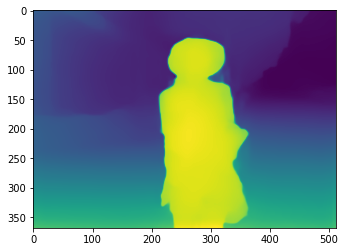

In [141]:
output = model.forward()
output = output[0, :, :]
output = cv2.resize(output, (imgWidth, imgHeight))
output = cv2.normalize(output, None, 0, 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
plt.imshow(output)

모델의 예측결과 가장 앞에 있다고 판단되는 객체는 노란색으로 표시하고 거리가 멀다고 판단할 수록 청색에서 검은색으로 바뀌어갑니다.

In [145]:
tmp_girl = cv2.normalize(tmp_girl, None, 0, 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
tmp_girl.shape

(368, 512, 3)

모델의 입력으로 들어간 데이터가 정규화가 되어졌기에 입력되는 새로운 데이터도 정규화를 시켜줘야 계산에 오류가 발생하지 않습니다.

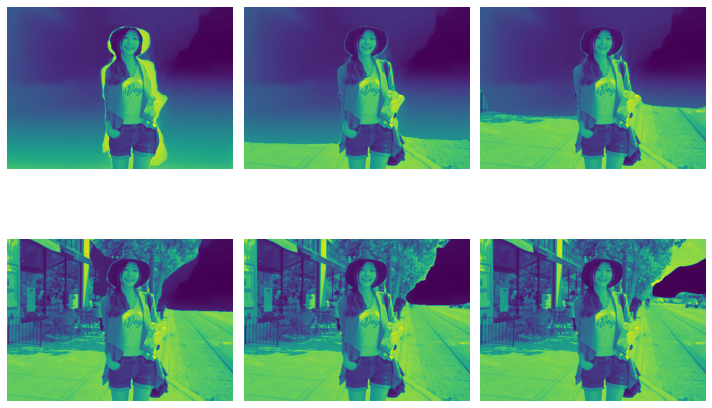

In [146]:
weights = [0.9, 0.5, 0.3, 0.1, 0.05, 0.01]
gray_tmp_girl = cv2.cvtColor(tmp_girl, cv2.COLOR_RGB2GRAY)

fig, axes = plt.subplots(2, 3, figsize = (10, 10))
axes = axes.ravel()

for ind, axis in enumerate(axes):
    tmp = np.where(output > weights[ind], gray_tmp_girl, output).copy()
    axis.imshow(tmp)
    axis.axis("off")

    plt.tight_layout()
plt.show()

결과값에 임계치를 각각 0.9, 0.5, 0.3, 0.1, 0.05, 0.01로 주는 경우를 시각화 하였더니 임계치가 낮아질수록 점점 멀리 있는 배경까지 포함되어진다는 것을 알 수가 있었습니다.

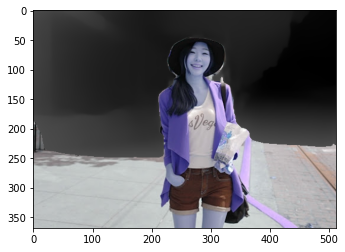

In [147]:
depth_img = defaultdict()
R_depth_img = (np.where(output > 0.3, tmp_girl[:,:,0], output) * 255).astype(np.uint8)
G_depth_img = (np.where(output > 0.3, tmp_girl[:,:,1], output) * 255).astype(np.uint8)
B_depth_img = (np.where(output > 0.3, tmp_girl[:,:,2], output) * 255).astype(np.uint8)
depth_img["girl"] = np.stack([B_depth_img, G_depth_img, R_depth_img], axis = 2)
depth_img = dict(depth_img)
plt.imshow(depth_img["girl"])

뒤에 사람이 보이지 않는 수준의 임계치인 0.3인 사진을 가지고 semetic segmentation 모델에 넣어서 사람의 위치를 예측하도록 하겠습니다.

girl
resize before : (368, 512, 3)
resize after : (368, 513, 3)
seg_map_max : 15


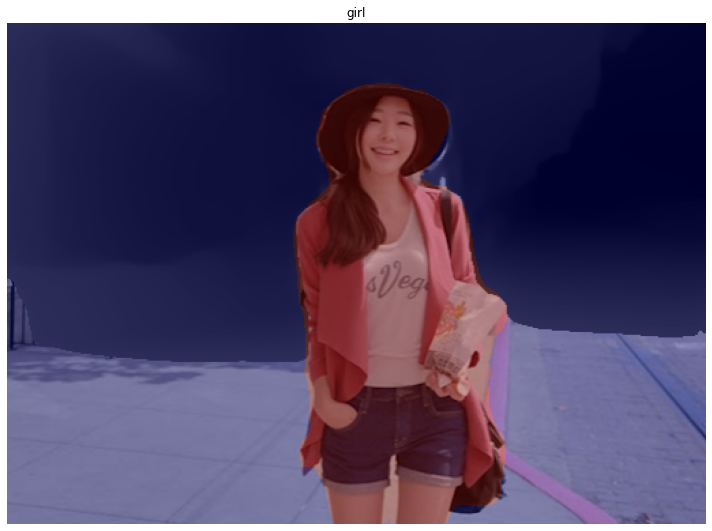

In [148]:
run_depth_img = img_mask_pred(depth_img)
depth_img_mask = mask_show(run_depth_img)

모델이 사람이라고 예측한 부분에 약간 빨간색의 마스크로 표시하였습니다.

In [149]:
background = defaultdict()
background["girl"] = img_orig["girl"].copy()
background = dict(background)

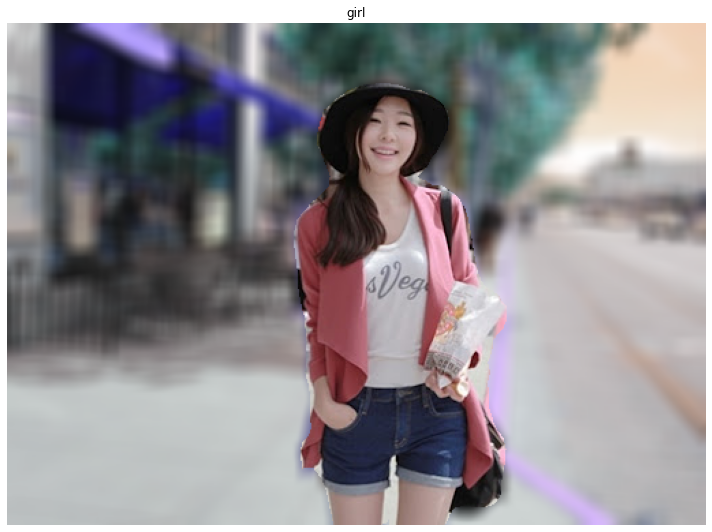

In [150]:
img_concat = dict(outfocus_filter(depth_img_mask, background))
show_images(img_concat)

마스크가 표시된 위치에 원본데이터를 넣고 나머지 부분은 blur 처리를 하여 아웃포커싱 효과를 만들어 주었습니다.

결과적으로는 문제로 삼았던 의문의 점을 없애는데 성공하였습니다.